# Development Notebook:

## SNR Region Extraction:

In [1]:
import Labber
import os
import sys
from fitTools.utilities import Watt2dBm, dBm2Watt, VNA2dBm

from twpa_tune_up_helper_functions import *


/Users/shanto/miniforge3/envs/lfl_qp/lib/python3.9/site-packages/qtpy/__init__.py:214: RuntimeWarning: Selected binding "pyqt5" could not be found, using "pyside6"
  warnings.warn('Selected binding "{}" could not be found, '


Labber File Location: data/TWPA_Tune_Up_No_LP_No_Ext_Final_Amp_092622.hdf5
Number of Repeations: 3
Number of Points for Power: 19
Number of Points for Frequency: 66


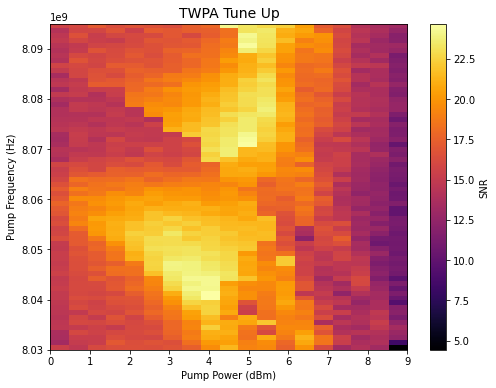

In [2]:
labber_data_file = str(input("Labber File Location: "))
repeated = int(input("Number of Repeations: "))
power_range = int(input("Number of Points for Power: "))
freq_range = int(input("Number of Points for Frequency: "))

std_highSNR = 1.15 # cut off point for determining high SNR
cutOff_around_SA_peak = 10e3 # Hz

lf = Labber.LogFile(labber_data_file)

power_channel_name = "10002F25 - Power"
freq_channel_name = "10002F25 - Frequency"
SA_channel_name = 'HP Spectrum Analyzer - Signal'

pump_power = lf.getData(name = power_channel_name)
pump_freq = lf.getData(name = freq_channel_name)

signal = lf.getData(name = SA_channel_name)
linsig = dBm2Watt(signal)

SAxdata, SAydata = lf.getTraceXY(y_channel=SA_channel_name) # gives last trace from SA

plt.rcParams['savefig.facecolor']='white'

get_SNR_space_plot(signal,repeated, freq_range, power_range, pump_freq,
                   pump_power, SAxdata, cutOff=cutOff_around_SA_peak,
                   title="TWPA Tune Up", xlabel='Pump Power (dBm)', 
                   ylabel='Pump Frequency (Hz)', zlabel='SNR', 
                   fig_type=".png", path="figures")




In [12]:
def get_config_for_high_SNR(arr,x,y,std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation
    print("hi")
    arr[arr < high_values] = np.nan
    return arr

def get_high_SNR_regions(signal,repeated, freq_range, power_range,pump_freq, pump_power, SAxdata, cutOff=10e3, std_highSNR=1.75):
    average_signal = get_average_of_N_traces(signal,repeated)
    average_lin_signal = dBm2Watt(average_signal)

    pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
    pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)

    SNRs, max_signals, noise_floors = calculate_SNRs(average_lin_signal,SAxdata,cutOff)
    SNRs_reshaped = np.reshape(SNRs, (freq_range,power_range))

    region = get_config_for_high_SNR(SNRs_reshaped,x=pump_powers, y=pump_freqs,std_dev=std_highSNR)
    meanSNR = np.mean(SNRs_reshaped)
    std_message = f"Region of High SNR\n[i.e SNR \$> mean(SNR) \ = {meanSNR}) * std_dev(SNR) = {std_highSNR}]"
    create_heatmap(region, pump_powers, pump_freqs, title = std_message, xlabel='Pump Power (dBm)', ylabel='Pump Frequency (Hz)', zlabel='SNR',)



hi


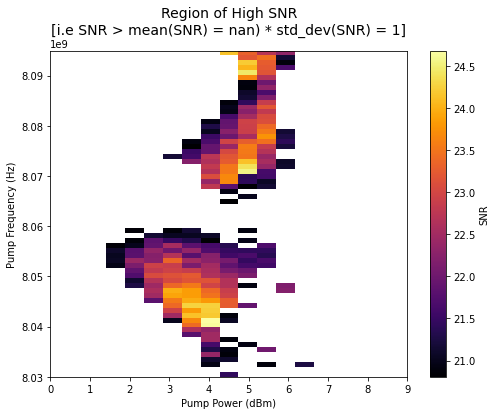

In [17]:
region = get_high_SNR_regions(signal,repeated, freq_range, power_range, pump_freq,
                         pump_power, SAxdata, cutOff=cutOff_around_SA_peak,
                         std_highSNR=1)

In [ ]:
cutOff = 10e3
average_signal = get_average_of_N_traces(signal,repeated)
average_lin_signal = dBm2Watt(average_signal)

pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)

SNRs, max_signals, noise_floors = calculate_SNRs(average_lin_signal,SAxdata,cutOff)
SNRs_reshaped = np.reshape(SNRs, (freq_range,power_range))


In [ ]:
arr = SNRs_reshaped
x=pump_powers
y=pump_freqs
std_dev=1.5

In [ ]:
matrix = np.random.rand(400,400)
plt.imshow(matrix, interpolation='none')
plt.show()

In [ ]:
matrix[matrix < 0.99] = np.nan

plt.imshow(matrix, interpolation='none')
plt.show()

In [ ]:
matrix

In [ ]:
def get_high_SNR_regions(signal,repeated, freq_range, power_range,pump_freq, pump_power, SAxdata, cutOff=10e3, std_highSNR=1.75):
    average_signal = get_average_of_N_traces(signal,repeated)
    average_lin_signal = dBm2Watt(average_signal)

    pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
    pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)

    SNRs, max_signals, noise_floors = calculate_SNRs(average_lin_signal,SAxdata,cutOff)
    SNRs_reshaped = np.reshape(SNRs, (freq_range,power_range))
    # SNRs_reshaped = np.reshape(SNRs, (power_range,freq_range)) # Original

    region = get_config_for_high_SNR(SNRs_reshaped,x=pump_powers, y=pump_freqs,std_dev=std_highSNR)
    meanSNR = np.mean(SNRs_reshaped)
    std_message = f"[i.e. SNR > mean(SNR) = {meanSNR}) * std_dev(SNR) = {std_highSNR}]"
    print("="*30+f"\n\nHigh SNR Regions:\n{std_message}\n\nFormat: (power,frequency,SNR)\n\n"+str(region).replace("), ","),\n ")+"\n\n"+"="*30)
    return region


In [ ]:
def get_config_for_high_SNR(arr,x,y,std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(arr)
    
    arr[arr < high_values] = np.nan
    
    axes[1].imshow(arr)
    
    fig.tight_layout()
    plt.show()
    
    """
    mask = (arr > high_values)
    indices = np.where(mask)
    
    snrs = arr[indices]
    xvals = x[indices[0]]
    yvals = y[indices[1]]
        
    return list(zip(xvals,yvals,snrs))
    """



In [ ]:
region = get_config_for_high_SNR(SNRs_reshaped,x=pump_powers, y=pump_freqs,std_dev=0)

In [ ]:
arr[arr < high_values] = np.nan

create_heatmap(arr, pump_powers, pump_freqs, title="TWPA Tune Up", xlabel='Pump Power (dBm)', ylabel='Pump Frequency (Hz)', zlabel='SNR', fig_type=".png", path="figures")



In [ ]:
1254/2

## SNR Methods

In [ ]:
import Labber
import os
import sys
from fitTools.utilities import Watt2dBm, dBm2Watt, VNA2dBm

from twpa_tune_up_helper_functions import *


In [ ]:
def calculate_mean_SNR_from_Labber_file(labber_data_file5, cutOff = 10e3):
    """
    """
    lf = Labber.LogFile(labber_data_file)
    SA_channel_name = 'HP Spectrum Analyzer - Signal'


    signal = lf.getData(name = SA_channel_name)
    linsig = dBm2Watt(signal)

    SAxdata, SAydata = lf.getTraceXY(y_channel=SA_channel_name, entry=0) # gives last trace from SA
    
    snrs = 0
    for i in range(len(signal)):
        snrs += get_signal_stats(dBm2Watt(signal[i]), SAxdata, cutOff)[0]

    snr_mean = snrs / len(signal)
    return snr_mean

**Testing SNR Code:**

In [ ]:
calculate_mean_SNR_from_Labber_file